NCE
aCO2:  58.16629500000015 5.5586677709321775
eCO2:  62.068504999999845 24.815701056001856
increase: 0.06708713353669317 3.902209999999704 24.78751496460771
aCO2:  44.37772999999977 13.12036142537049
eCO2:  116.96477000000009 13.422773675133229
increase: 1.635663653819172 72.58704000000031 5.296777258215417
aCO2:  -7.281484999999956 24.422709182974465
eCO2:  -4.273509999999803 29.019185846499063
increase: -0.41309911371103164 3.0079750000001533 15.427212384338938
aCO2:  -44.484670000000065 37.62522314650905
eCO2:  19.940379999999912 38.919797960759766
increase: -1.4482528475539973 64.42504999999998 12.623365375514995
aCO2:  -65.00817999999998 40.98567102933171
eCO2:  55.62142500000014 33.663589139112936
increase: -1.855606555974958 120.62960500000011 27.09015385889493
0 ('a', 'b')
GPP
aCO2:  143.59320500000007 71.27622384109827
eCO2:  597.8340249999999 145.3105831833645
increase: 3.1633865961832917 454.24081999999987 100.98850561050804
aCO2:  203.8510049999999 91.40532188844692
eCO2:

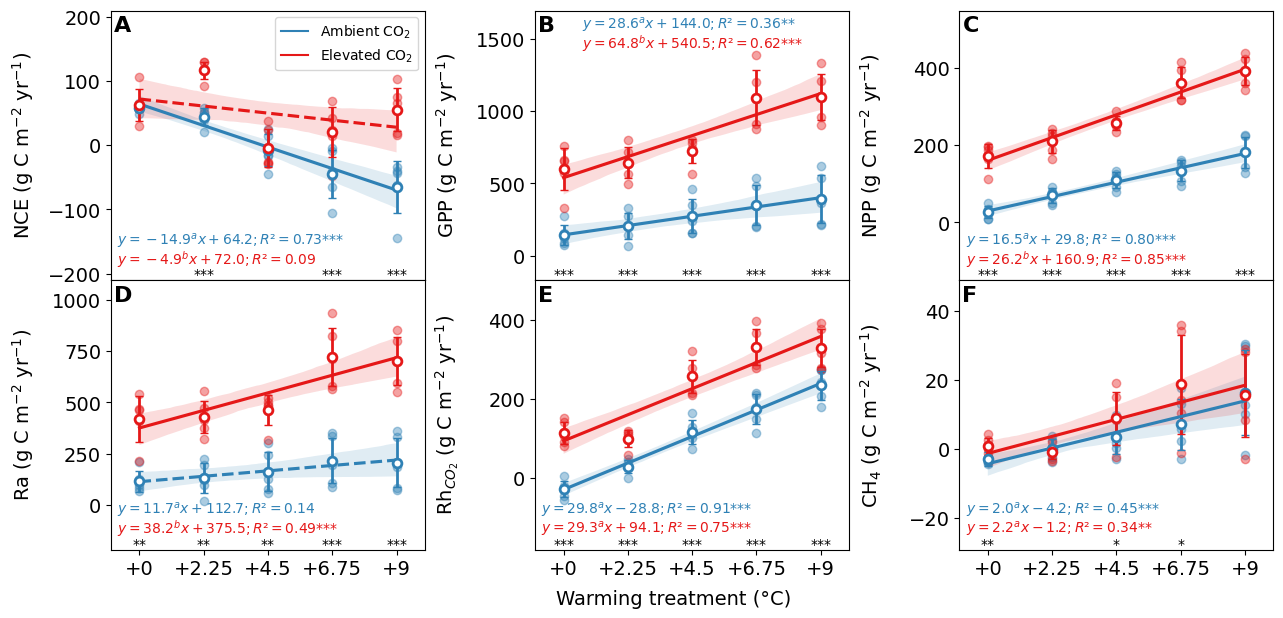

In [1]:
# figure-1: NCE, NPP, Ra and CH4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import wilcoxon

# Configuration settings
# plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

# Constants
WARMING_LEVELS = [0, 2.25, 4.5, 6.75, 9]  # Warming levels in °C
WARM_PLOTS         = ["P06", "P20", "P13", "P08", "P17"]              # Plot numbers for warming treatments
ELEVATED_CO2_PLOTS = ["P19", "P11", "P04", "P16", "P10"]      # Plot numbers for warming + elevated CO2

# Variables to plot (NCE, NPP, Rh, CH4)
VARIABLES = [
    {'name': 'NCE', 'ylabel': 'NCE (g C m$^{-2}$ yr$^{-1}$)', 'ylim': (-210, 210)},
    {'name': 'GPP', 'ylabel': 'GPP (g C m$^{-2}$ yr$^{-1}$)', 'ylim': (-169, 1699)},
    {'name': 'NPP', 'ylabel': 'NPP (g C m$^{-2}$ yr$^{-1}$)', 'ylim': (-149, 549)},
    {'name': 'Ra',  'ylabel': 'Ra (g C m$^{-2}$ yr$^{-1}$)', 'ylim': (-219, 1099)},
    {'name': 'Rh',  'ylabel': 'Rh$_{CO_2}$ (g C m$^{-2}$ yr$^{-1}$)', 'ylim': (-180, 500)},
    {'name': 'CH4', 'ylabel': 'CH$_4$ (g C m$^{-2}$ yr$^{-1}$)', 'ylim': (-29, 49)}
]

COLORS = {
    'ambient': "#2F81B5",# '#145390',# '#004697', # '#4A8CC3', # '#EAB080', # '#2F81B5',
    'elevated': "#E51818" # '#E51818' # '#E37939', # '#7C9D97'# ''
}

ls_pos  = [(0.02, 0.11, 0.04), (0.15, 0.91, 0.84), (0.02, 0.11, 0.04), 
           (0.02, 0.11, 0.04), (0.02, 0.11, 0.04), (0.02, 0.11, 0.04)]

dis = 0

def load_and_prepare_data(filepath):
    """Load and prepare the data for analysis."""
    df = pd.read_excel(filepath)
    
    # Select relevant columns and filter years
    df = df[df["year"] > 2016]
    
    return df

def calculate_fluxes(df):
    """Calculate the carbon fluxes from the raw data."""
    # Calculate each flux component
    df['NCE'] = (df["gpp_Tree"] + df["gpp_Shrub"] + df["gpp_Sphagnum"] - 
                (df["ra_Tree"] + df["ra_Shrub"] + df["ra_Sphagnum"]) - 
                df["rh"] - df["ch4"])
    df['GPP'] = df["gpp_Tree"] + df["gpp_Shrub"] + df["gpp_Sphagnum"]
    df['NPP'] = (df["npp_Tree"] + df["npp_Shrub"] + df["npp_Sphagnum"])
    df["Ra"]  = (df["ra_Tree"] + df["ra_Shrub"] + df["ra_Sphagnum"])
    df['Rh'] = df["rh"]
    
    df['CH4'] = df["ch4"]
    
    return df

def fit_model(x, y, max_order=2):
    """Fit linear and quadratic models and select the best one based on AIC."""
    results = {}
    
    for order in [1, 2]:
        if order == 1:
            X = sm.add_constant(x)
        else:
            X = sm.add_constant(np.column_stack((x, x**2)))
            
        model = sm.OLS(y, X).fit()
        results[order] = {
            'model': model,
            'aic': model.aic,
            'bic': model.bic,
            'r2': model.rsquared,
            'pvalue': model.f_pvalue
        }
    
    # Select best model (difference in AIC > 4 means significantly better)
    if abs(results[1]['aic'] - results[2]['aic']) > 4:
        best_order = 2 if results[2]['aic'] < results[1]['aic'] else 1
    else:
        best_order = 1  # Default to simpler model if difference is small
    
    return results[best_order], best_order

import statsmodels.api as sm
import statsmodels.formula.api as smf

# def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
#     # create two group datasets
#     x = np.concatenate([x1, x2])
#     y = np.concatenate([y1, y2])
#     group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

#     # create a model include interactive object
#     data = {'y': y, 'x': x, 'group': group}
#     model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

#     pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
#     pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

#     if pvalue_diff_slope < 0.05:
#         res_ab_slope = ("a", "b")
#     else:
#         res_ab_slope = ("a", "a")

#     if pvalue_diff_intercept < 0.05:
#         res_ab_intercept = ("a", "b")
#     else:
#         res_ab_intercept = ("a", "a")

#     return res_ab_slope, res_ab_intercept

def cal_reg_diff(x_ambient, y_ambient, x_elevated, y_elevated):
    """
    Fits y ~ x + group + x:C(group) and returns the p‑values for
    differences in slope and intercept between the two groups.  If only
    one group is present the p‑values will be None.
    """
    # Create a DataFrame with a categorical group column
    x = np.concatenate([x_ambient, x_elevated])
    y = np.concatenate([y_ambient, y_elevated])
    group_labels = (['ambient'] * len(x_ambient)) + (['elevated'] * len(x_elevated))
    df = pd.DataFrame({'y': y, 'x': x, 'group': group_labels})
    df['group'] = df['group'].astype('category')

    # Fit the model
    model = smf.ols('y ~ x + group + x:C(group)', data=df).fit()

    # Dynamically extract p‑values for group effects
    slope_pval = None
    intercept_pval = None
    for term, pval in model.pvalues.items():
        if term.startswith('x:C(group)'):
            slope_pval = pval
        elif term.startswith('C(group)'):
            intercept_pval = pval

    # slope_pval and intercept_pval will be None if there is only one group
    if slope_pval is not None and slope_pval < 0.05:
        res_ab_slope = ('a', 'b')
    else:
        res_ab_slope = ('a', 'a')

    if intercept_pval is not None and intercept_pval < 0.05:
        res_ab_intercept = ('a', 'b')
    else:
        res_ab_intercept = ('a', 'a')

    return res_ab_slope, res_ab_intercept

def format_equation(params, order, r2, pvalue, ab_slope, ab_inter):
    """Format the regression equation as a string."""
    if order == 1:
        b, a = params
        sign_b = '-' if b < 0 else '+'
        equation = f"$y = {a:.1f}^{ab_slope}x {sign_b} {abs(b):.1f}; R² = {r2:.2f}$"
    else:
        c, b, a = params
        sign_b = '-' if b < 0 else '+'
        sign_c = '-' if c < 0 else '+'
        equation = f"$y = {a:.1f}x² {sign_b} {abs(b):.1f}x {sign_c} {abs(c):.1f}; R² = {r2:.2f}$"
    
    # Add significance stars
    if pvalue < 0.001:
        equation += "***"
    elif pvalue < 0.01:
        equation += "**"
    elif pvalue < 0.05:
        equation += "*"
    
    return equation

def plot_flux(ax, df, flux_name, ylabel, ylim, i_pos):
    """Plot a single carbon flux."""
    # Prepare data
    x_ambient = []
    x_elevated = []
    y_ambient = []
    y_elevated = []
    mean_ambient = []
    mean_elevated = []
    std_ambient = []
    std_elevated = []

    ambient_data_by_level = []
    elevated_data_by_level = []
    
    for warm_plot, co2_plot in zip(WARM_PLOTS, ELEVATED_CO2_PLOTS):
        
        # Ambient CO2 data
        ambient_data = df[df["plot"] == warm_plot]["warming"].values
        x_ambient.extend(ambient_data)
        iwarm = ambient_data[0]
        ambient_data = df[df["plot"] == warm_plot][flux_name].values
        y_ambient.extend(ambient_data)
        mean_ambient.append(np.nanmean(ambient_data))
        std_ambient.append(np.nanstd(ambient_data))
        ambient_data_by_level.append(ambient_data)
        print("aCO2: ", np.nanmean(ambient_data), np.nanstd(ambient_data))
        
        # Elevated CO2 data
        elevated_data = df[df["plot"] == co2_plot]["warming"].values
        x_elevated.extend(elevated_data)
        elevated_data = df[df["plot"] == co2_plot][flux_name].values
        y_elevated.extend(elevated_data)
        mean_elevated.append(np.nanmean(elevated_data))
        std_elevated.append(np.nanstd(elevated_data))
        elevated_data_by_level.append(elevated_data)
        print("eCO2: ", np.nanmean(elevated_data), np.nanstd(elevated_data))

        print("increase:", (np.nanmean(elevated_data) - np.nanmean(ambient_data))/np.nanmean(ambient_data), np.mean(elevated_data-ambient_data), np.std(elevated_data-ambient_data))
        
        # Test for significant differences between treatments
        _, p_value = stats.ttest_rel(ambient_data, elevated_data)
        # _, p_value = wilcoxon(ambient_data, elevated_data)
        # print(p_value)
        
        # Add significance marker if p < 0.05
        if p_value < 0.05:
            marker = '*' if p_value < 0.05 else ''
            marker = '**' if p_value < 0.01 else marker
            marker = '***' if p_value < 0.001 else marker
            ax.text(iwarm, ylim[0] + 0.02*(ylim[1]-ylim[0]), 
                   marker, ha='center', va='center', fontsize=10)
    
    # Plot raw data points
    ax.scatter(np.array(x_ambient) - dis, y_ambient, alpha=0.4, color=COLORS['ambient'], zorder=1)
    ax.scatter(np.array(x_elevated) + dis, y_elevated, alpha=0.4, color=COLORS['elevated'], zorder=1)
    
    # Plot means and error bars
    ax.errorbar(np.array(WARMING_LEVELS) - dis, mean_ambient, yerr=std_ambient, 
                fmt='none', ecolor=COLORS['ambient'], capsize=3, linewidth=2, zorder=2)
    ax.errorbar(np.array(WARMING_LEVELS) + dis, mean_elevated, yerr=std_elevated, 
                fmt='none', ecolor=COLORS['elevated'], capsize=3, linewidth=2, zorder=2)
    
    # Plot mean points
    ax.scatter(np.array(WARMING_LEVELS) - dis, mean_ambient, marker='o', s=40, 
               color='white', edgecolor=COLORS['ambient'], linewidth=2, zorder=3)
    ax.scatter(np.array(WARMING_LEVELS) + dis, mean_elevated, marker='o', s=40, 
               color='white', edgecolor=COLORS['elevated'], linewidth=2, zorder=3)
    
    # Fit and plot regression lines
    mark_order = 0
    for treatment, color in [('Ambient', COLORS['ambient']), ('Elevated', COLORS['elevated'])]:
        x_data = x_ambient if treatment == "Ambient" else x_elevated
        y_data = y_ambient if treatment == 'Ambient' else y_elevated
        x_array = np.array(x_data)
        y_array = np.array(y_data)
        
        # Fit model
        model, order = fit_model(x_array, y_array)
        line_style = '-' if model['pvalue'] < 0.05 else '--'

        sns.regplot(x=x_data, y=y_data, 
                order=order,ax=ax, 
                # scatter_kws={'alpha': 0.7, 'color':color},
                scatter=False,
                line_kws={"linestyle": line_style},  
                color=color,label=f'{treatment} CO$_2$',) 

        if order == 2: mark_order = 1

    if mark_order == 0:
        res_ab_slope, res_ab_intercept = cal_reg_diff(x_ambient, y_ambient, x_elevated, y_elevated)
    else:
        res_ab_slope, res_ab_intercept = ('\u200B', '\u200B'), ('\u200B', '\u200B')
    print(mark_order, res_ab_slope)
    
    for treatment, color in [('Ambient', COLORS['ambient']), ('Elevated', COLORS['elevated'])]:
        x_data = x_ambient if treatment == "Ambient" else x_elevated
        y_data = y_ambient if treatment == 'Ambient' else y_elevated
        x_array = np.array(x_data)
        y_array = np.array(y_data)
        
        # Fit model
        model, order = fit_model(x_array, y_array)
        
        # Add equation text
        # print("test:",res_ab_slope)
        ab_slope = res_ab_slope[0]     if treatment == "Ambient" else res_ab_slope[1]
        ab_inter = res_ab_intercept[0] if treatment == "Ambient" else res_ab_intercept[1]
        equation = format_equation(model['model'].params, order, model['r2'], model['pvalue'], ab_slope, ab_inter)
        y_pos = i_pos[1] if treatment == 'Ambient' else i_pos[2]
        ax.text(i_pos[0], y_pos, equation, transform=ax.transAxes, 
                color=color, fontsize=10, va='bottom')
    
    # Set axis properties
    ax.set_xlim(-1, 10)
    ax.set_ylim(ylim)
    # ax.set_ylabel(ylabel)
    ax.text(-0.28, 0.5, ylabel, ha='center', va='center',rotation='vertical',transform=ax.transAxes,fontsize=14)
    # ax.set_xlabel('Warming (°C)' if ax.get_subplotspec().is_last_row() else '')
    ax.set_xticks(WARMING_LEVELS)
    ax.set_xticklabels([f'+{w}' for w in WARMING_LEVELS])
    
    return ax

def main():
    # Load and prepare data
    df = load_and_prepare_data("1_data_noacc_minus_2013.xlsx")
    df = calculate_fluxes(df)
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    axes = axes.flatten()
    
    # Plot each flux
    for idx, (ax, var_info) in enumerate(zip(axes, VARIABLES)):
        print(var_info['name'])
        plot_flux(ax, df, var_info['name'], var_info['ylabel'], var_info['ylim'], ls_pos[idx])
        # ax.set_title(f"({chr(97+axes.tolist().index(ax))}) {var_info['name']}", loc='left')
        ax.text(
            0.01, 0.98, chr(65 + axes.tolist().index(ax)),
            transform=ax.transAxes,   
            fontsize=16,
            va='top',
            ha='left',
            fontweight='bold'
        )
    
    # Add legend (only once)
    handles = [
        plt.Line2D([], [], color=COLORS['ambient'],  linestyle='-', label='Ambient CO$_2$'),
        plt.Line2D([], [], color=COLORS['elevated'],  linestyle='-', label='Elevated CO$_2$')
    ]
    axes[0].legend(handles=handles, loc='upper right', fontsize=10)

    fig.text(0.5, 0.04, 'Warming treatment (°C)', ha='center', va='center', fontsize=14)
    # Adjust layout
    plt.subplots_adjust(hspace=0, wspace=0.35)
    # plt.tight_layout()
    # plt.savefig('carbon_fluxes_plot.png', dpi=300, bbox_inches='tight')
    # plt.savefig("2_results/5_figures/fig_1.pdf", dpi=300, format="pdf", bbox_inches='tight')#, transparent=True)
    plt.show()

if __name__ == "__main__":
    main()

